In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from textblob import TextBlob

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from google.colab import files
uploaded=files.upload()

Saving upload_DJIA_table.csv to upload_DJIA_table.csv


In [4]:
df=pd.read_csv("Combined_News_DJIA.csv")
dj=pd.read_csv("upload_DJIA_table.csv")

In [5]:
# Combine news headlines as one column
df["combined news"]=df.loc[:,"Top1":"Top25"].astype(str).agg(" ".join,axis=1)

In [6]:
#cleaning the text column

stop=set(stopwords.words("english"))
lemmatizer=WordNetLemmatizer()

def clean_text(text):
  text=re.sub(r"b[\"']"," ",text.lower())
  text=re.sub(r"\[.*?\]\(.*?\)","",text)
  text=re.sub(r"[^\w\s]"," ",text)
  text=re.sub(r"\s+"," ",text)
  tokens=word_tokenize(text)
  output=[lemmatizer.lemmatize(words) for words in tokens if words.isalpha() and words not in stop]
  return " ".join(output)

df["clean text"]=df["combined news"].apply(clean_text)

In [7]:

#train test split
train = df[df['Date']<'20150101']
test = df[df['Date'] > '20141231']

In [8]:
#merge the news dataset and stock price dataset
df_merged=pd.merge(df,dj,on="Date",how="inner")

In [9]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.4 MB/s eta 0:00:00


In [10]:
#we use VADER Sentiment Analyzer to evaluate the sentiment of "clean text" column

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyse=SentimentIntensityAnalyzer()
analyse.polarity_scores(df["clean text"][1])   # Calculate sentiment scores of the text

{'neg': 0.284, 'neu': 0.613, 'pos': 0.103, 'compound': -0.9895}

In [15]:
# define a function to apply VADER sentiment analysis to any given text
def get_sentiment(text):
    return analyse.polarity_scores(str(text))

In [16]:
# three functions to extract sentiment features from TextBlob and VADER

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment= sia.polarity_scores(text)
    return sentiment

In [17]:
# apply the TextBlob sentiment functions to the clean text column in df_merged and store the results in two new columns: 'Subjectivity' and 'Polarity'

df_merged['Subjectivity'] = df_merged['clean text'].apply(get_subjectivity)
df_merged['Polarity'] = df_merged['clean text'].apply(get_polarity)

In [18]:
# get Sentiment score for each day
# use VADER to calculate four types of sentiment scores

compound = []
neg = []
pos = []
neu = []

for i in range(len(df["clean text"])):
    SIA = get_sentiment(df["clean text"].iloc[i])
    compound.append(SIA["compound"])
    neg.append(SIA["neg"])
    pos.append(SIA["pos"])
    neu.append(SIA["neu"])

df["compound"] = compound
df["neg"] = neg
df["pos"] = pos
df["neu"] = neu

In [19]:
df_merged["compound"]=compound
df_merged["neg"]=neg
df_merged["pos"]=pos
df_merged["neu"]=neu

In [21]:
# Prepare Features & Target
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close',
            'compound', 'neg', 'pos', 'neu', 'Polarity', 'Subjectivity']
X = df_merged[features]
y = df_merged["Label"]

In [22]:
# Time-based Split
train = df_merged[df_merged['Date'] < '20150101']
test  = df_merged[df_merged['Date'] > '20141231']
train_idx = train.index
test_idx = test.index

X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [ ]:
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [24]:
# evaluate seven machine learning classification models for predicting stock movement

# the models we want to test
models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "Naive Bayes": GaussianNB(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "xgboost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis()
}
for name, model in models.items():
    if name=="Naive Bayes":
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)
    else:
        model.fit(X_train,y_train)
        y_pred=model.predict(X_test)
        y_pred_train=model.predict(X_train)
    print(f"{name}")
    print("train accuracy: ",accuracy_score(y_train,y_pred_train))
    print("test accuracy: ",accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print("*"*50)

LogisticRegression
train accuracy:  0.9860440150295223
test accuracy:  0.9788359788359788
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       186
           1       0.98      0.98      0.98       192

    accuracy                           0.98       378
   macro avg       0.98      0.98      0.98       378
weighted avg       0.98      0.98      0.98       378

[[182   4]
 [  4 188]]
**************************************************
Naive Bayes
train accuracy:  0.548040794417606
test accuracy:  0.5105820105820106
              precision    recall  f1-score   support

           0       0.60      0.02      0.03       186
           1       0.51      0.99      0.67       192

    accuracy                           0.51       378
   macro avg       0.55      0.50      0.35       378
weighted avg       0.55      0.51      0.36       378

[[  3 183]
 [  2 190]]
**************************************************
SVC
train accuracy:  0.549

In [26]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Define your models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naive Bayes": GaussianNB(),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "LDA": LinearDiscriminantAnalysis()
}

# List to store results
results = []

# Loop over each model
for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute metrics
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test, average='weighted')  # or macro/micro

    # Append results
    results.append({
        "Model": name,
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4),
        "F1 Score": round(f1, 4)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display
print(results_df.sort_values(by="Test Accuracy", ascending=False))


                 Model  Train Accuracy  Test Accuracy  F1 Score
0  Logistic Regression          0.9860         0.9788    0.9788
4              XGBoost          0.9984         0.9577    0.9577
6                  LDA          0.9324         0.9497    0.9496
5        Random Forest          1.0000         0.9471    0.9471
3                  KNN          0.6887         0.6111    0.6098
2                  SVC          0.5491         0.5106    0.3571
1          Naive Bayes          0.5480         0.5106    0.3571


# **Regression**

In [ ]:

# Use SAME features, but target is 'Adj Close'
X = df_merged[features]
y = df_merged[["Adj Close"]]


In [ ]:
X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]
y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

# --- MinMax Scale ---
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled  = X_scaler.transform(X_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled  = y_scaler.transform(y_test)

In [ ]:

# --- Create Sequences ---
SEQ_LEN = 10
def create_sequences(X, y, seq_len=SEQ_LEN):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQ_LEN)

In [ ]:

# --- LSTM Model ---
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, X_train_seq.shape[2])),
    Dropout(0.1),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(32),
    Dropout(0.1),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=8,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)],
    verbose=1
)

Epoch 1/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0225 - val_loss: 9.4066e-04
Epoch 2/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 3/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0026 - val_loss: 7.6102e-04
Epoch 4/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0024 - val_loss: 8.8513e-04
Epoch 5/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 6/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0018 - val_loss: 7.4241e-04
Epoch 10/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 11/200
209/209 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0014 - val_loss: 7.6015e-04
Epoch 12/

In [ ]:

# --- Evaluation ---
y_pred = model.predict(X_test_seq)
y_test_inv = y_scaler.inverse_transform(y_test_seq)
y_pred_inv = y_scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

print(f"📊 MSE: {mse:.4f}")
print(f"📉 RMSE: {rmse:.4f}")
print(f"📈 MAE: {mae:.4f}")
print(f"🎯 R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
📊 MSE: 33605.3333
📉 RMSE: 183.3176
📈 MAE: 141.1524
🎯 R² Score: 0.9166
MAPE: 0.82%


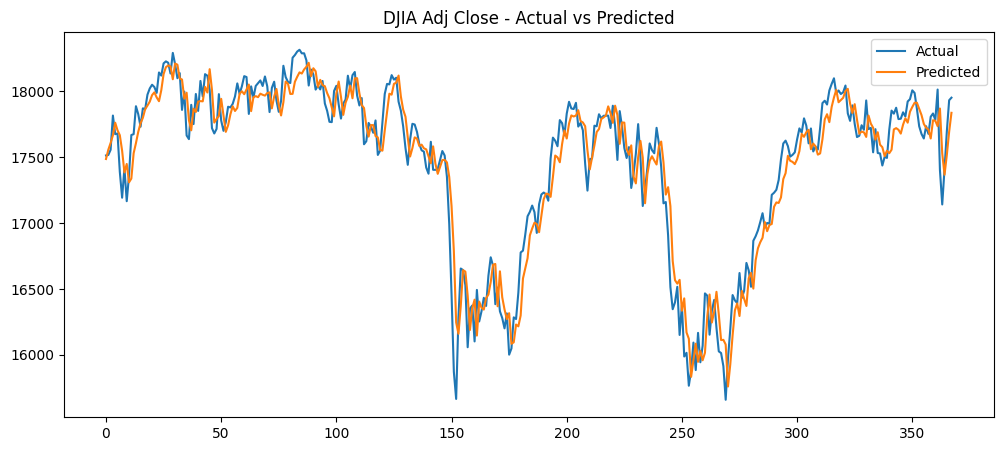

In [ ]:

plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.legend()
plt.title('DJIA Adj Close - Actual vs Predicted')
plt.show()


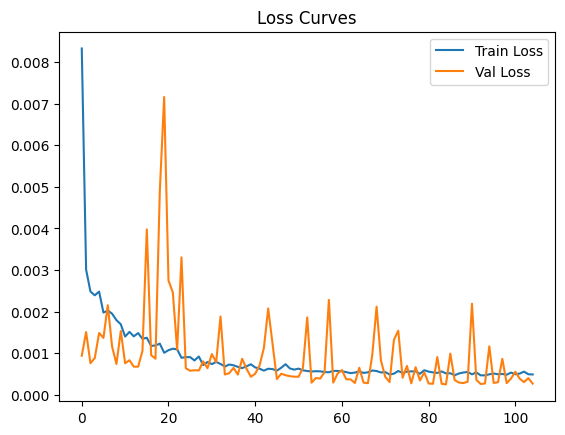

In [ ]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()


In [ ]:

train_preds = model.predict(X_train_seq)
print("Train R²:", r2_score(y_scaler.inverse_transform(y_train_seq), y_scaler.inverse_transform(train_preds)))
print("Val R²:", r2_score(y_test_inv, y_pred_inv))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Train R²: 0.9978432252397745
Val R²: 0.9165600527610313
